# Importación de librerias

In [ ]:
!pip install git+https://github.com/forrestbao/pyeeg.git

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyeeg
import math

import os
import seaborn as sn

from collections import Counter

#Importación de librerías de Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import tensorflow as tf

import joblib
from joblib import dump, load

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-08kzs9jb
  Running command git clone --filter=blob:none --quiet https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-08kzs9jb
  Resolved https://github.com/forrestbao/pyeeg.git to commit a6c18bb093e4748f9d9c208535a6ae024a0802b8
  Preparing metadata (setup.py) ... done
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Lectura de archivos y extracción de características por epoch

> Se realiza la extracción de todos los archivos que serviran para el entrenamiento del modelo de Machine Learning



In [ ]:
FOLDER_PATH = 'Tesis/Concentracion'
ROOT_PATH = '/content/drive/MyDrive/'
files_quantity = len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH)))

sfreq = 1000 # Frecuencia a la que toma datos el BIOPAC
t_epoch = 10 # Se realiza un epoch cada 10 segundos
t_relajacion = 60 #Tiempo en segundos
t_concentracion = 180 # Tiempo en segundos
band_freq = [0.5,4,7,12,30]
sujeto = 1
prueba = 1                            #'Condicion','Power Alpha','Power Beta','Power Alpha Normalized', 'Power Beta Normalized'
epochs_trained = pd.DataFrame(columns=['Condicion','Power Alpha','Power Beta','Power Alpha Normalized', 'Power Beta Normalized'])

tests_to_evaluate = 1
tests_per_subject = 3
no_subjects = (files_quantity//tests_per_subject)
files_to_analyze = no_subjects*tests_to_evaluate

discarded_subjects = [5,11,12]

def extractPSD(PSD_value):
  return [PSD_value[0][0], PSD_value[0][1], PSD_value[0][2], PSD_value[0][3], PSD_value[1][0], PSD_value[1][1], PSD_value[1][2], PSD_value[1][3]]

def extractHjorth(Hjorth_value):
  return [Hjorth_value[0],Hjorth_value[1]]


for i in range(files_to_analyze):
  if sujeto in discarded_subjects:
    sujeto = sujeto + 1
  else:
    if sujeto < 10:
      subject = '0' + str(sujeto)
    else:
      subject = str(sujeto)
    df=pd.read_csv('/content/drive/MyDrive/Tesis/Concentracion/'+subject+'0'+str(prueba)+'.csv')
    print('Lectura de archivo: '+subject+'0'+str(prueba)+'.csv')
    sujeto = sujeto + 1
    df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
    epochs = []
    j = 0
    for k in range(len(df)):
      epochs.append(j)
      if (k+1) % (sfreq*t_epoch) == 0:
        j += 1
    df.insert(0,'Epoch',epochs)
    df2 = pd.DataFrame(columns=['EEG','Epoch'])
    df2['EEG'], df2['Epoch'] = df['EEG'], df['Epoch']
    temp=df2.groupby(['Epoch']).agg([pyeeg.dfa,
                                        #lambda x: pyeeg.hurst(x.tolist()),
                                        lambda x: pyeeg.hfd(x.tolist(),5),
                                        # lambda x: pyeeg.spectral_entropy(x.tolist(),band_list,freq,Power_Ratio=None),
                                        lambda x: pyeeg.fisher_info(x.tolist(),4,10),
                                        # lambda x: pyeeg.svd_entropy(x),
                                        # lambda x: pyeeg.ap_entropy(x,10,0.3*(np.std(x))),
                                        lambda x: pyeeg.svd_entropy(x,4,10),
                                        lambda x: pyeeg.bin_power(x, band_freq, sfreq),
                                        lambda x: pyeeg.pfd(x, np.diff(x).tolist()),
                                        lambda x: pyeeg.hjorth(x.tolist(), np.diff(x).tolist())])

    temp.reset_index(inplace=True,drop=False)
    temp.columns=['epoch','DFA','HFD','Fisher Info','SVD Entropy','PSD','PFD','Hjorth']

    temp[['Power Delta',
        'Power Theta',
        'Power Alpha',
        'Power Beta',
        'Power Delta Normalized',
        'Power Theta Normalized',
        'Power Alpha Normalized',
        'Power Beta Normalized']] = temp['PSD'].apply(lambda x: pd.Series(extractPSD(x)))
    temp = temp.drop('PSD', axis=1)

    temp[['Hjorth Mobility','Hjorth Complexity']] = temp['Hjorth'].apply(lambda x: pd.Series(extractHjorth(x)))
    temp = temp.drop('Hjorth', axis=1)

    final_features = ['Power Alpha','Power Beta','Power Alpha Normalized', 'Power Beta Normalized']
    temp = temp[final_features]

    label_relajacion = np.zeros((t_relajacion//t_epoch,1),dtype=np.int8)
    label_concentracion = np.ones((t_concentracion//t_epoch,1),dtype=np.int8)
    labels = np.concatenate((label_relajacion,label_concentracion))
    temp.insert(0,'Condicion',labels)
    epochs_trained.append(temp)
    epochs_trained = pd.concat([epochs_trained,temp], ignore_index=True, sort=False)

display(epochs_trained)

Lectura de archivo: 0101.csv


<ipython-input-84-3073b3fcf5a6>:39: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=

Lectura de archivo: 0201.csv


<ipython-input-84-3073b3fcf5a6>:39: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=

Lectura de archivo: 0301.csv


<ipython-input-84-3073b3fcf5a6>:39: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=

Lectura de archivo: 0401.csv


/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Alpha = numpy.linalg.lstsq(numpy.vstack(
/usr/local/lib/python3.10/dist-packages/pyeeg/fractal_dimension.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N

Lectura de archivo: 0601.csv


/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Alpha = numpy.linalg.lstsq(numpy.vstack(
/usr/local/lib/python3.10/dist-packages/pyeeg/fractal_dimension.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N

Lectura de archivo: 0701.csv


/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Alpha = numpy.linalg.lstsq(numpy.vstack(
/usr/local/lib/python3.10/dist-packages/pyeeg/fractal_dimension.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N

Lectura de archivo: 0801.csv


/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Alpha = numpy.linalg.lstsq(numpy.vstack(
/usr/local/lib/python3.10/dist-packages/pyeeg/fractal_dimension.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N

Lectura de archivo: 0901.csv


/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Alpha = numpy.linalg.lstsq(numpy.vstack(
/usr/local/lib/python3.10/dist-packages/pyeeg/fractal_dimension.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N

Lectura de archivo: 1001.csv


/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Alpha = numpy.linalg.lstsq(numpy.vstack(
/usr/local/lib/python3.10/dist-packages/pyeeg/fractal_dimension.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N

,Condicion,Power Alpha,Power Beta,Power Alpha Normalized,Power Beta Normalized
0,0,70645.285448,249269.591651,0.107799,0.380365
1,0,82707.312255,252756.679326,0.128278,0.392021
2,0,92035.313623,283941.026778,0.124378,0.383723
3,0,101357.487885,252117.978949,0.142037,0.353306
4,0,77938.842444,290757.684652,0.117469,0.438228
...,...,...,...,...,...
211,1,80357.814237,224290.568365,0.149742,0.417952
212,1,86309.395196,395081.448043,0.112025,0.512794
213,1,97365.116119,229254.481980,0.145093,0.341633
214,1,86757.917243,223652.972223,0.173782,0.447993


In [ ]:
epochs_trained['Condicion'] = pd.to_numeric(epochs_trained['Condicion'])
print(epochs_trained.dtypes)

Condicion                   int64
Power Alpha               float64
Power Beta                float64
Power Alpha Normalized    float64
Power Beta Normalized     float64
dtype: object


# Conteo de datos de cada etiqueta

In [ ]:
q_labels = epochs_trained.Condicion.value_counts()
features=epochs_trained.iloc[:,1:].columns.tolist()
epochs_trained = epochs_trained.sample(frac=1).reset_index(drop=True)

In [ ]:
#epochs_trained.sort_values(by=['Condicion'],inplace=True)
#epochs_trained.reset_index(drop=True,inplace=True)
display(epochs_trained)

,Condicion,Power Alpha,Power Beta,Power Alpha Normalized,Power Beta Normalized
0,1,156907.903079,6.050523e+05,0.118142,0.455568
1,1,89029.944984,7.089120e+05,0.086059,0.685253
2,1,96412.931403,4.178730e+05,0.152177,0.659567
3,1,96921.998355,3.446165e+05,0.132135,0.469819
4,0,82707.312255,2.527567e+05,0.128278,0.392021
...,...,...,...,...,...
211,1,126058.092294,1.088271e+06,0.082902,0.715697
212,1,130625.371768,7.025654e+05,0.111423,0.599288
213,0,113439.027069,3.126405e+05,0.162375,0.447510
214,1,275130.457720,6.996145e+05,0.118115,0.300348


#### Selección de datos de entrenamiento balanceados según el número menor de alguna de las etiquetas

In [ ]:
min_q = min(q_labels)
innatentive_data = epochs_trained[epochs_trained.Condicion == 0]
innatentive_data = innatentive_data.head(min_q)
concentration_data = epochs_trained[epochs_trained.Condicion == 1]
concentration_data = concentration_data.head(min_q)
balanced_data = pd.concat([innatentive_data,concentration_data],ignore_index=True,sort=False)
display(balanced_data)

,Condicion,Power Alpha,Power Beta,Power Alpha Normalized,Power Beta Normalized
0,0,82707.312255,2.527567e+05,0.128278,0.392021
1,0,99412.070989,5.007216e+05,0.099541,0.501369
2,0,67139.248140,1.751408e+05,0.167473,0.436873
3,0,96938.844096,3.268883e+05,0.131794,0.444422
4,0,131239.393123,5.031411e+05,0.145109,0.556314
...,...,...,...,...,...
103,1,161561.413234,6.318836e+05,0.098301,0.384465
104,1,85826.584203,5.592940e+05,0.108363,0.706155
105,1,180264.932326,1.313122e+06,0.100561,0.732526
106,1,73290.601605,5.960129e+05,0.088622,0.720692


In [ ]:
features

['Power Alpha',
 'Power Beta',
 'Power Alpha Normalized',
 'Power Beta Normalized']

In [ ]:
balanced_data = balanced_data.sample(frac=1).reset_index(drop=True)
display(balanced_data)
X = balanced_data[features].values
X

,Condicion,Power Alpha,Power Beta,Power Alpha Normalized,Power Beta Normalized
0,0,84863.360762,4.794161e+05,0.114398,0.646265
1,1,222761.710916,1.288683e+06,0.101314,0.586107
2,1,140334.601192,5.381049e+05,0.118496,0.454366
3,0,73959.538368,1.738551e+05,0.174583,0.410388
4,0,208727.197069,1.700499e+05,0.391551,0.318996
...,...,...,...,...,...
103,1,113025.252422,6.460229e+05,0.113044,0.646128
104,1,94619.505830,4.413023e+05,0.146460,0.683083
105,0,57574.846360,1.303367e+05,0.147056,0.332901
106,1,90838.429918,3.343745e+05,0.148439,0.546403


array([[8.48633608e+04, 4.79416121e+05, 1.14397886e-01, 6.46264655e-01],
       [2.22761711e+05, 1.28868347e+06, 1.01314400e-01, 5.86106977e-01],
       [1.40334601e+05, 5.38104886e+05, 1.18495880e-01, 4.54365577e-01],
       [7.39595384e+04, 1.73855068e+05, 1.74582721e-01, 4.10387780e-01],
       [2.08727197e+05, 1.70049904e+05, 3.91550510e-01, 3.18995931e-01],
       [8.90299450e+04, 7.08911951e+05, 8.60587004e-02, 6.85253049e-01],
       [6.73945273e+04, 1.17249210e+05, 2.07487156e-01, 3.60974492e-01],
       [1.87142193e+05, 7.31838702e+05, 7.73715167e-02, 3.02569235e-01],
       [1.36681872e+05, 9.40328039e+05, 1.07782714e-01, 7.41510971e-01],
       [6.86915783e+04, 1.46336977e+05, 1.85510853e-01, 3.95202701e-01],
       [1.22496428e+05, 5.14800605e+05, 1.01872880e-01, 4.28128566e-01],
       [1.14814571e+05, 2.80057224e+05, 1.73835703e-01, 4.24022351e-01],
       [1.21710846e+05, 9.06456211e+05, 9.94151755e-02, 7.40406516e-01],
       [1.52170319e+05, 9.01429830e+05, 1.23129466e

In [ ]:
Y = balanced_data['Condicion'].values
Y

array([0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,random_state=54)

In [ ]:
balanced_data.to_csv('Caracteristicas_EEG_Concentracion.csv')

#### Selección de datos de entrenamiento balanceados mediante la generación de datos sintéticos mediante el algoritmo SMOTE ~ prueba 1

In [ ]:
X_old = epochs_trained[features].values
Y_old = epochs_trained['Condicion'].values

print('Tamaño original de la data: %s' % Counter(Y_old))
sm = SMOTE(random_state=54)
X, Y = sm.fit_resample(X_old,Y_old)
print('Tamaño re-muestreada de la data: %s' % Counter(Y))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,random_state=54)

Tamaño original de la data: Counter({1: 162, 0: 54})
Tamaño re-muestreada de la data: Counter({1: 162, 0: 162})


#### Selección de datos de entrenamiento balanceados mediante la generación de datos sintéticos mediante el algoritmo SMOTE ~ prueba 2

In [ ]:
X = epochs_trained[features].values
Y = epochs_trained['Condicion'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=54)
print('Tamaño original de la data para entrenar: %s' % Counter(Y_train))

sm = SMOTE(random_state=54)
X_train ,Y_train = sm.fit_resample(X_train,Y_train)
print('Tamaño re-muestreada de la data para entrenar: %s' % Counter(Y_train))

Tamaño original de la data para entrenar: Counter({1: 121, 0: 41})
Tamaño re-muestreada de la data para entrenar: Counter({1: 121, 0: 121})


#### Entrenar con toda la data disponible sin tomar en cuenta la cantidad de data de cada una de las etiquetas

In [ ]:
X = epochs_trained[features].values
Y = epochs_trained['Condicion'].values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=54)

# Clasificador SVM
###### Se toma este clasificador como primera opción ya que en un artículo se desarolló el mismo para predecir los estados de concentración o inatención. Mas información en: [A machine learning-based decision support system for temporal human cognitive state estimation during online education using wearable physiological monitoring devices](https://https://www.sciencedirect.com/science/article/pii/S2772662223001200)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=54)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

In [ ]:
Y_test

array([0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1])

In [ ]:
clf_svm = SVC(kernel='linear',random_state=94)
clf_svm_train = clf_svm.fit(X_train,Y_train)
predictions = clf_svm.predict(X_train)

AttributeError: ignored

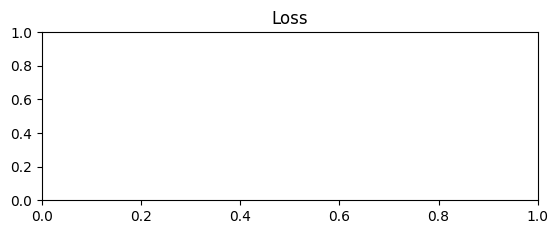

In [ ]:
# Se grafica la evolución de la pérdida durante el entrenamiento y la
# validación
plt.subplot(211)
plt.title('Loss')
plt.plot(clf_svm_train.history['loss'], label='train')
plt.plot(clf_svm_train.history['val_loss'], label='test')
plt.legend()
# Se grafica la evolución de la exactitud durante el entrenamiento y la
# validación
plt.subplot(212)
plt.title('Accuracy')
plt.plot(clf_svm_train.history['accuracy'], label='train')
plt.plot(clf_svm_train.history['val_accuracy'], label='test')
plt.legend()
plt.show()

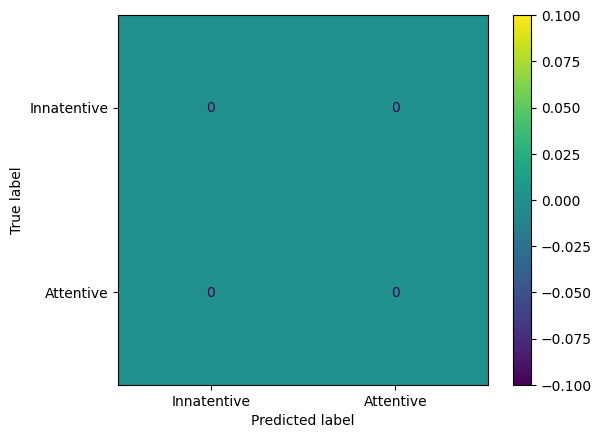

In [ ]:

cm = confusion_matrix(Y_train,predictions,labels=['0','1'])
disp = ConfusionMatrixDisplay(cm,display_labels=['Innatentive','Attentive'])
disp.plot()
plt.show()

# Clasificador Random Forest

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=82,verbose=1,n_jobs=3,max_depth=15)
model.fit(X_train,Y_train)
predicts = model.predict(X_test)
print('Cantidad de datos para entrenamiento: '+str(len(X_train)))
print('Cantidad de datos para testeo: '+str(len(X_test)))

Cantidad de datos para entrenamiento: 81
Cantidad de datos para testeo: 27


[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.1s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


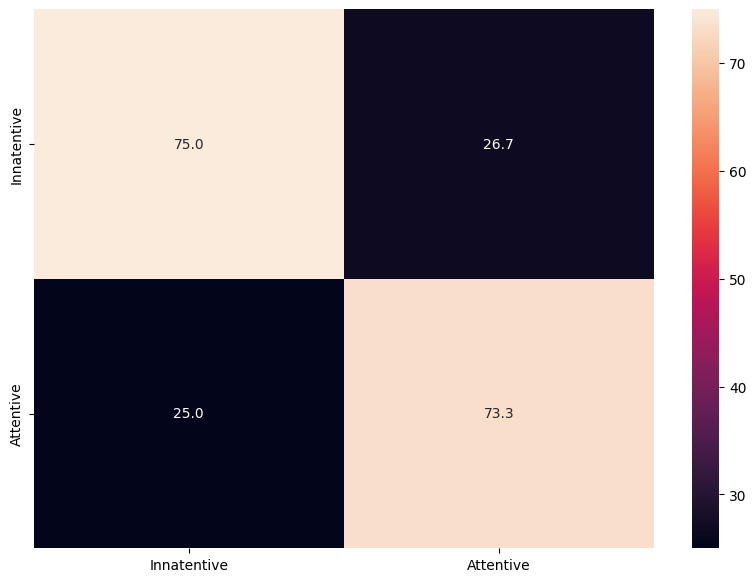

In [ ]:
df_cm = pd.DataFrame(confusion_matrix(Y_test, predicts,normalize='pred'), index = ['Innatentive','Attentive'],
                  columns = ['Innatentive','Attentive'])

df_cm=df_cm*100

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, fmt=".1f")
plt.show()

In [ ]:
dump(model, 'RandomForest.joblib')

['RandomForest.joblib']

Syntethic Minority Over-sampling Technique

# Clasificador CNN

In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Tesis/Concentracion/0101.csv')
df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
epochs = []
j = 0
for k in range(len(df)):
  epochs.append(j)
  if (k+1) % (sfreq*t_epoch) == 0:
    j += 1
df.insert(0,'Epoch',epochs)
temp = df.groupby('Epoch')['EEG'].apply(list).reset_index(name='EEG')
display(temp)


In [ ]:
FOLDER_PATH = 'Tesis/Concentracion'
ROOT_PATH = '/content/drive/MyDrive/'
files_quantity = len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH)))

sfreq = 1000 # Frecuencia a la que toma datos el BIOPAC
t_epoch = 10 # Se realiza un epoch cada 10 segundos
t_relajacion = 60 #Tiempo en segundos
t_concentracion = 180 # Tiempo en segundos

tests_to_evaluate = 1
tests_per_subject = 3
no_subjects = (files_quantity//tests_per_subject)
files_to_analyze = no_subjects*tests_to_evaluate
sujeto = 1
prueba = 1

discarded_subjects = [5,11,12]

df2 = pd.DataFrame(columns=['Epoch','EEG'])

for i in range(files_to_analyze):
  if sujeto in discarded_subjects:
    sujeto = sujeto + 1
  else:
    if sujeto < 10:
      subject = '0' + str(sujeto)
    else:
      subject = str(sujeto)
    df=pd.read_csv('/content/drive/MyDrive/Tesis/Concentracion/'+subject+'0'+str(prueba)+'.csv')
    print('Lectura de archivo: '+subject+'0'+str(prueba)+'.csv')
    sujeto = sujeto + 1
    df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
    epochs = []
    j = 0
    for k in range(len(df)):
      epochs.append(j)
      if (k+1) % (sfreq*t_epoch) == 0:
        j += 1
    df.insert(0,'Epoch',epochs)
    temp = df.groupby('Epoch')['EEG'].apply(list).reset_index(name='EEG')
    label_relajacion = np.zeros((t_relajacion//t_epoch,1),dtype=np.int8)
    label_concentracion = np.ones((t_concentracion//t_epoch,1),dtype=np.int8)
    labels = np.concatenate((label_relajacion,label_concentracion))
    temp.insert(0,'Condicion',labels)
    df2 = pd.concat([df2,temp],ignore_index=True,sort=False)

df2['Condicion'] = pd.to_numeric(df2['Condicion'])
df2.drop('Epoch',axis=1,inplace=True)
display(df2)

In [ ]:
X_train.shape[1]

2

In [ ]:
layer1 = tf.keras.layers.Dense(1, activation='relu')
nnm = tf.keras.Sequential(layer1)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.7)
nnm.compile(loss='binary_crossentropy',optimizer=opt,metrics='accuracy')

# Y_test = Y_test.reshape((-1,1))
# Y_train = Y_train.reshape((-1,1))

nnm_train = nnm.fit(X_train,Y_train,validation_data=(X_test,Y_test),epochs=100)
_,train_acc = nnm.evaluate(X_train,Y_train, verbose=0)
_,test_acc = nnm.evaluate(X_test,Y_test, verbose = 0)
print('Train %.3f, Test: %.3f' %(train_acc,test_acc))

Epoch 1/100
3/3 [==============================] - 1s 110ms/step - loss: 0.6368 - accuracy: 0.6420 - val_loss: 0.6185 - val_accuracy: 0.7407
Epoch 2/100
3/3 [==============================] - 0s 31ms/step - loss: 0.5709 - accuracy: 0.7037 - val_loss: 0.6196 - val_accuracy: 0.6296
Epoch 3/100
3/3 [==============================] - 0s 33ms/step - loss: 0.5712 - accuracy: 0.7284 - val_loss: 0.6383 - val_accuracy: 0.5926
Epoch 4/100
3/3 [==============================] - 0s 33ms/step - loss: 0.5707 - accuracy: 0.7284 - val_loss: 0.6274 - val_accuracy: 0.6296
Epoch 5/100
3/3 [==============================] - 0s 20ms/step - loss: 0.5652 - accuracy: 0.7407 - val_loss: 0.6143 - val_accuracy: 0.6296
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 0.5644 - accuracy: 0.6790 - val_loss: 0.6143 - val_accuracy: 0.6296
Epoch 7/100
3/3 [==============================] - 0s 13ms/step - loss: 0.5642 - accuracy: 0.6790 - val_loss: 0.6144 - val_accuracy: 0.6296
Epoch 8/100
3/3 [==

# Impacto de pulsos binaurales en concentración

In [ ]:
FOLDER_PATH = 'Tesis/Concentracion'
ROOT_PATH = '/content/drive/MyDrive/'
files_quantity = len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH)))

sfreq = 1000 # Frecuencia a la que toma datos el BIOPAC
t_epoch = 10 # Se realiza un epoch cada 10 segundos
t_relajacion = 60 #Tiempo en segundos
t_concentracion = 180 # Tiempo en segundos
band_freq = [0.5,4,7,12,30]
sujeto = 1
prueba = 2
epochs_test = pd.DataFrame(columns=['Power Alpha','Power Beta','Power Alpha Normalized', 'Power Beta Normalized'])

tests_to_evaluate = 2
tests_per_subject = 3
no_subjects = (files_quantity//tests_per_subject)
files_to_analyze = no_subjects*tests_to_evaluate

def extractPSD(PSD_value):
  return [PSD_value[0][0], PSD_value[0][1], PSD_value[0][2], PSD_value[0][3], PSD_value[1][0], PSD_value[1][1], PSD_value[1][2], PSD_value[1][3]]

def extractHjorth(Hjorth_value):
  return [Hjorth_value[0],Hjorth_value[1]]


for i in range(files_to_analyze):
  df=pd.read_csv('/content/drive/MyDrive/Tesis/Concentracion/'+'0'+str(sujeto)+'0'+str(prueba)+''.csv')
  print('Lectura de archivo: '+'0'+str(sujeto)+'0'+str(prueba)+'.csv')
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
  df.drop(df.index[:t_relajacion*sfreq],0,inplace=True) #Se descarta el primer minuto de relajación
  epochs = []
  j = 0
  for k in range(len(df)):
    epochs.append(j)
    if (k+1) % (sfreq*t_epoch) == 0:
      j += 1
  df.insert(0,'Epoch',epochs)
  df2 = pd.DataFrame(columns=['EEG','Epoch'])
  df2['EEG'], df2['Epoch'] = df['EEG'], df['Epoch']
  temp=df2.groupby(['Epoch']).agg([pyeeg.dfa,
                                      #lambda x: pyeeg.hurst(x.tolist()),
                                       lambda x: pyeeg.hfd(x.tolist(),5),
                                       # lambda x: pyeeg.spectral_entropy(x.tolist(),band_list,freq,Power_Ratio=None),
                                       lambda x: pyeeg.fisher_info(x.tolist(),4,10),
                                       # lambda x: pyeeg.svd_entropy(x),
                                       # lambda x: pyeeg.ap_entropy(x,10,0.3*(np.std(x))),
                                       lambda x: pyeeg.svd_entropy(x,4,10),
                                       lambda x: pyeeg.bin_power(x, band_freq, sfreq),
                                       lambda x: pyeeg.pfd(x, np.diff(x).tolist()),
                                       lambda x: pyeeg.hjorth(x.tolist(), np.diff(x).tolist())])

  temp.reset_index(inplace=True,drop=False)
  temp.columns=['epoch','DFA','HFD','Fisher Info','SVD Entropy','PSD','PFD','Hjorth']

  temp[['Power Delta',
      'Power Theta',
      'Power Alpha',
      'Power Beta',
      'Power Delta Normalized',
      'Power Theta Normalized',
      'Power Alpha Normalized',
      'Power Beta Normalized']] = temp['PSD'].apply(lambda x: pd.Series(extractPSD(x)))
  temp = temp.drop('PSD', axis=1)

  temp[['Hjorth Mobility','Hjorth Complexity']] = temp['Hjorth'].apply(lambda x: pd.Series(extractHjorth(x)))
  temp = temp.drop('Hjorth', axis=1)

  final_features = ['Power Alpha','Power Beta', 'Power Alpha Normalized', 'Power Beta Normalized']
  temp = temp[final_features]
  epochs_test.append(temp)
  if prueba == 3:
    prueba = 2
    sujeto =+1
  else:
    prueba =+ 1
  epochs_test = pd.concat([epochs_test,temp], ignore_index=True, sort=False)

display(epochs_test)

Lectura de archivo: 0103.csv


<ipython-input-122-0e8c537d5451>:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
<ipython-input-122-0e8c537d5451>:30: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[:t_relajacion*sfreq],0,inplace=True) #Se descarta el primer minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages

Lectura de archivo: 0203.csv


<ipython-input-122-0e8c537d5451>:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
<ipython-input-122-0e8c537d5451>:30: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[:t_relajacion*sfreq],0,inplace=True) #Se descarta el primer minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages

Lectura de archivo: 0303.csv


<ipython-input-122-0e8c537d5451>:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
<ipython-input-122-0e8c537d5451>:30: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[:t_relajacion*sfreq],0,inplace=True) #Se descarta el primer minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages

Lectura de archivo: 0403.csv


<ipython-input-122-0e8c537d5451>:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
<ipython-input-122-0e8c537d5451>:30: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[:t_relajacion*sfreq],0,inplace=True) #Se descarta el primer minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages

Lectura de archivo: 0503.csv


<ipython-input-122-0e8c537d5451>:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
<ipython-input-122-0e8c537d5451>:30: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[:t_relajacion*sfreq],0,inplace=True) #Se descarta el primer minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages

Lectura de archivo: 0603.csv


<ipython-input-122-0e8c537d5451>:29: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[(t_relajacion+t_concentracion)*sfreq:],0,inplace=True) #Se descarta el último minuto de relajación
<ipython-input-122-0e8c537d5451>:30: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.index[:t_relajacion*sfreq],0,inplace=True) #Se descarta el primer minuto de relajación
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages

,Power Alpha,Power Beta,Power Alpha Normalized,Power Beta Normalized
0,93884.102173,284862.296046,0.158562,0.481107
1,92700.632736,294317.488191,0.125721,0.399153
2,87436.982735,277066.375709,0.146412,0.463943
3,77765.073329,284509.562946,0.134667,0.492690
4,93958.898073,237329.498263,0.183503,0.463508
...,...,...,...,...
103,88169.702304,217232.944943,0.169085,0.416593
104,88297.154369,209126.021138,0.179915,0.426117
105,88880.150654,236512.468512,0.135247,0.359896
106,69965.805337,218251.042897,0.143230,0.446790


# Evaluación de impacto de pulsos binaurales con KMeans Clustering


## Extracción de datos

In [ ]:
FOLDER_PATH = 'Tesis/Concentracion/Extendida'
ROOT_PATH = '/content/drive/MyDrive/'
files_quantity = len(os.listdir(os.path.join(ROOT_PATH, FOLDER_PATH)))

sfreq = 1000 # Frecuencia a la que toma datos el BIOPAC
t_epoch = 30 # Se realiza un epoch cada 30 segundos
band_freq = [0.5,4,7,12,30]
sujeto = 6
prueba = 1

tests_to_evaluate = 2
tests_per_subject = 2
no_subjects = (files_quantity//tests_per_subject)
files_to_analyze = no_subjects*tests_to_evaluate


def extractPSD(PSD_value):
  return [PSD_value[0][0], PSD_value[0][1], PSD_value[0][2], PSD_value[0][3], PSD_value[1][0], PSD_value[1][1], PSD_value[1][2], PSD_value[1][3]]

def extractHjorth(Hjorth_value):
  return [Hjorth_value[0],Hjorth_value[1]]


for i in range(files_to_analyze):
    subject = '0' + str(sujeto)
    df=pd.read_csv('/content/drive/MyDrive/Tesis/Concentracion/Extendida/'+subject+'0'+str(prueba)+'.csv')
    print('Lectura de archivo: '+subject+'0'+str(prueba)+'.csv')
    epochs = []
    j = 0
    for k in range(len(df)):
      epochs.append(j)
      if (k+1) % (sfreq*t_epoch) == 0:
        j += 1
    df.insert(0,'Epoch',epochs)
    df2 = pd.DataFrame(columns=['EEG','Epoch'])
    df2['EEG'], df2['Epoch'] = df['EEG'], df['Epoch']
    temp=df2.groupby(['Epoch']).agg([pyeeg.dfa,
                                        #lambda x: pyeeg.hurst(x.tolist()),
                                        lambda x: pyeeg.hfd(x.tolist(),5),
                                        # lambda x: pyeeg.spectral_entropy(x.tolist(),band_list,freq,Power_Ratio=None),
                                        lambda x: pyeeg.fisher_info(x.tolist(),4,10),
                                        # lambda x: pyeeg.svd_entropy(x),
                                        # lambda x: pyeeg.ap_entropy(x,10,0.3*(np.std(x))),
                                        lambda x: pyeeg.svd_entropy(x,4,10),
                                        lambda x: pyeeg.bin_power(x, band_freq, sfreq),
                                        lambda x: pyeeg.pfd(x, np.diff(x).tolist()),
                                        lambda x: pyeeg.hjorth(x.tolist(), np.diff(x).tolist())])

    temp.reset_index(inplace=True,drop=False)
    temp.columns=['epoch','DFA','HFD','Fisher Info','SVD Entropy','PSD','PFD','Hjorth']

    temp[['Power Delta',
        'Power Theta',
        'Power Alpha',
        'Power Beta',
        'Power Delta Normalized',
        'Power Theta Normalized',
        'Power Alpha Normalized',
        'Power Beta Normalized']] = temp['PSD'].apply(lambda x: pd.Series(extractPSD(x)))
    temp = temp.drop('PSD', axis=1)

    temp[['Hjorth Mobility','Hjorth Complexity']] = temp['Hjorth'].apply(lambda x: pd.Series(extractHjorth(x)))
    temp = temp.drop('Hjorth', axis=1)
    final_features = ['Power Alpha Normalized', 'Power Beta Normalized']
    temp = temp[final_features]
    temp.to_csv(subject+'0'+str(prueba)+'_ext_carac.csv')
    if prueba == 2:
      sujeto = sujeto + 1
    else:
      prueba = prueba + 1

Lectura de archivo: 0601.csv


/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Alpha = numpy.linalg.lstsq(numpy.vstack(
/usr/local/lib/python3.10/dist-packages/pyeeg/fractal_dimension.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N

Lectura de archivo: 0602.csv


/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  F[i] += numpy.linalg.lstsq(c, y)[1]
/usr/local/lib/python3.10/dist-packages/pyeeg/detrended_fluctuation_analysis.py:129: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Alpha = numpy.linalg.lstsq(numpy.vstack(
/usr/local/lib/python3.10/dist-packages/pyeeg/fractal_dimension.py:22: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N

## Scaling the data

In [ ]:
sub_to_an = 6
if sub_to_an < 10:
  sub_to_an = '0' + str(sub_to_an)
else:
  sub_to_an = str(sub_to_an)
df = pd.read_csv('/content/drive/MyDrive/Tesis/Concentracion/Extendida/'+sub_to_an+'01_ext_carac.csv')
df2 = pd.read_csv('/content/drive/MyDrive/Tesis/Concentracion/Extendida/'+sub_to_an+'02_ext_carac.csv')
scaler = StandardScaler()
df[['Power Alpha Normalized_T','Power Beta Normalized_T']] = scaler.fit_transform(df[['Power Alpha Normalized','Power Beta Normalized']])
df2[['Power Alpha Normalized_T','Power Beta Normalized_T']] = scaler.fit_transform(df2[['Power Alpha Normalized','Power Beta Normalized']])

## KMeans Clustering

In [ ]:
#Sin pulsos binaurales
kmeans = KMeans(n_clusters=2)
kmeans.fit(df[['Power Alpha Normalized_T','Power Beta Normalized_T']])
#Con pulsos binaurales
kmeans2 = KMeans(n_clusters=2)
kmeans2.fit(df2[['Power Alpha Normalized_T','Power Beta Normalized_T']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=2)

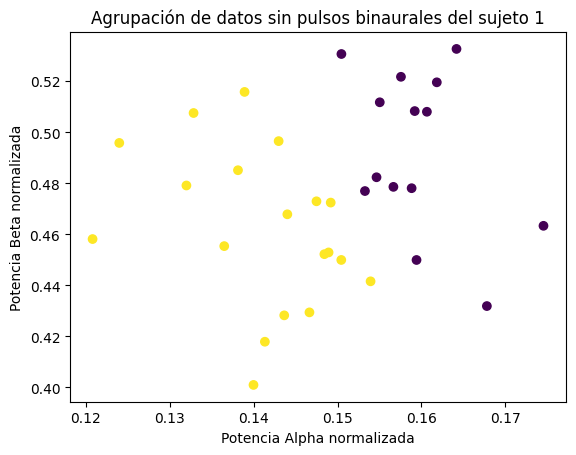

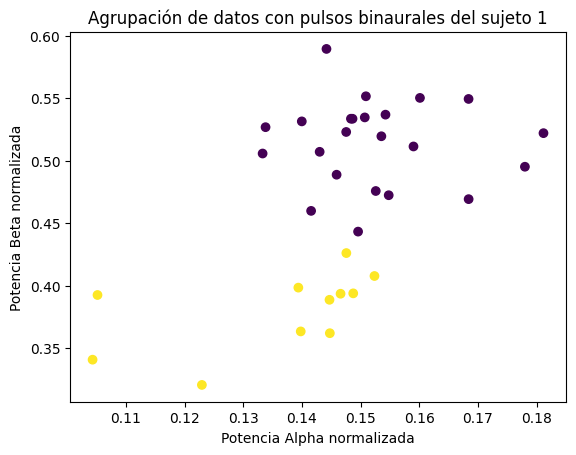

In [ ]:
#Sin pulsos binaurales
df['k_means2'] = kmeans.labels_
plt.scatter(x=df['Power Alpha Normalized'],y=df['Power Beta Normalized'],c=df['k_means2'])
plt.title('Agrupación de datos sin pulsos binaurales del sujeto 1')
plt.xlabel('Potencia Alpha normalizada')
plt.ylabel('Potencia Beta normalizada')
plt.savefig('kmeans_sujeto1_sin_pulsos.eps',format='eps')
plt.show()

#Con pulsos binaurales
df2['k_means2'] = kmeans2.labels_
plt.scatter(x=df2['Power Alpha Normalized'],y=df2['Power Beta Normalized'],c=df2['k_means2'])
plt.xlabel('Potencia Alpha normalizada')
plt.ylabel('Potencia Beta normalizada')
plt.title('Agrupación de datos con pulsos binaurales del sujeto 1')
plt.savefig('kmeans_sujeto1_con_pulsos.eps',format='eps')
plt.show()